In [177]:
# import dependencies
import os
import seaborn as sns
from datetime import datetime
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.fft import fft
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.tsatools import detrend

In [178]:
START = datetime(2016, 1, 1)
END = datetime(2021, 2, 16)
BUCKET = 1  # day

In [179]:
# Load data
global_markets_volumes_path = "data/VOLUMES.csv"
vix_path = "data/VIX.csv"
sp500_path = "data/SP500.csv"
gold_path= "data/GOLD.csv"
euro_usd_path = "data/EURUSD.csv"
bonds_path = "data/10YBONDYIELDS.csv"

In [180]:
def load_data(path: str, target:str) -> pd.DataFrame:
    assert target in ["gm", "vix", "sp500", "gold", "eurusd", "bonds"], f"Invaid target: {target}"

    root = os.path.dirname(os.getcwd())
    df = pd.read_csv(f"{root}/{path}")

    # rename columns to lower case
    df.columns = map(str.lower, df.columns)
    if target == "gm":
        index = "business date"
    else:
        index = "date"
    new_columns = ["date"] + [column + f"_{target}" for column in df.columns if column != index]
    # Add _target to columns except Date
    df.rename(columns=dict(zip(df.columns, new_columns)),inplace=True)
    # Remove space from columns
    df.columns = df.columns.str.replace(" ", "_")
    return df.set_index("date")

def join_dfs(df_list: List) -> pd.DataFrame:
    pdf = df_list[0]
    for df in df_list[1:]:
        pdf = pdf.join(df, how="left")
    assert len(pdf) == len(df_list[0])
    return pdf

In [181]:
gm_volumes = load_data(global_markets_volumes_path, "gm")
vix = load_data(vix_path, "vix")
sp500 = load_data(sp500_path, "sp500")
gold = load_data(gold_path, "gold")
euro_usd = load_data(euro_usd_path, "eurusd")
bonds = load_data(bonds_path, "bonds")

In [182]:
all_dfs = [gm_volumes, vix, sp500, gold, euro_usd, bonds]
all_data = join_dfs(all_dfs)
all_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,volume_bonds
date,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,0.0
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,0.0
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,0.0
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,0.0
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,0.0
...,...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133,0.0
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158,0.0
2/12/2021,3232.310708,19.97,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.200,0.0


In [183]:
# Remove bonds
data_no_bond_vol = all_data.drop(columns="volume_bonds")
data_no_bond_vol

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130
...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158
2/12/2021,3232.310708,19.97,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.200


In [184]:
data_no_bond_vol[data_no_bond_vol.isna().any(axis=1)]

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,
1/18/2016,1245.635545,NaN,NaN,NaN,NaN,NaN,1.0892,NaN
2/15/2016,1070.457234,NaN,NaN,NaN,NaN,NaN,1.1180,NaN
3/25/2016,2.655447,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3/28/2016,28.294602,15.24,2037.050049,2.809090e+09,1219.900024,33.0,NaN,1.87
5/30/2016,484.661910,NaN,NaN,NaN,NaN,NaN,1.1139,NaN
...,...,...,...,...,...,...,...,...
11/26/2020,3013.808951,NaN,NaN,NaN,NaN,NaN,1.1900,NaN
11/27/2020,3520.232596,20.84,3638.350098,2.778450e+09,NaN,NaN,1.1922,NaN
12/24/2020,936.569447,21.53,3703.060059,1.885090e+09,NaN,NaN,1.2193,NaN


TODO:
- Interpolate - Done (maybe better after adding lags)
- Remove constant values from volume_gm - Done
- Add target values - Done
- Remove trend from gold price and sp price - Done. Not convinced if it is useful
- Cap outliers - Done
- Add lag 1, 2 and/or 3 to volume and vix - Done
- Split in train, test
- Log transform volume_gm and vix
- Create baseline movng average model
- Train ML model
- Deploy

In [208]:
interpolated_data = data_no_bond_vol.interpolate()
interpolated_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.2450
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.2480
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.1770
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.1530
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.1300
...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.1330
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.1580
2/12/2021,3232.310708,19.970,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.2000


In [209]:
interpolated_data[interpolated_data.isna().any(axis=1)]

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,


In [225]:
def get_train_test_indexes(df: pd.DataFrame, test_size: float):
    test_len = int(df.shape[0] * test_size)
    train_len = int(df.shape[0] - test_len)

    train_indexes = list(range(train_len))
    test_indexes = list(range(train_len, df.shape[0]))
    return train_indexes, test_indexes


def add_lags(df:pd.DataFrame, cols: List[str] = ["volume_gm", "vix_close_vix"], periods: List[int] = [1, 2, 3]) -> tuple[pd.DataFrame, List]:
    lags_columns = []
    for col in cols:
        for lag in periods:
            feature_col_name = f"{col}_lag_{lag}"
            df[feature_col_name] = df.shift(lag)[col]
            lags_columns.append(feature_col_name)

    return df, lags_columns


def cap_outliers(df: pd.DataFrame, columns, train_indexes, std_num=4):
    means = df.iloc[train_indexes].mean(numeric_only=True)
    stds = df.iloc[train_indexes].std(numeric_only=True)
    for column in columns:
        up_border = means[column] + std_num * stds[column]
        down_border = max(0, means[column] - std_num * stds[column])
        df[column] = df[column].clip(lower=down_border, upper=up_border)
    return df


def cap_outliers_simple(df: pd.DataFrame):
    for col in df.columns:
        percentiles = df[col].quantile([0.01, 0.99]).values
        df[col] = np.clip(df[col], percentiles[0], percentiles[1])
    return df



In [226]:
# Add target values
interpolated_data_reduced = interpolated_data[interpolated_data["volume_gm"] != 1000]
interpolated_data_reduced["target"] = interpolated_data_reduced["volume_gm"].shift(-1)
interpolated_data_reduced = interpolated_data_reduced.iloc[:-1]
interpolated_data_reduced

/var/folders/hg/wkh3wd0x2cdgx68tgss9y0cr0000gn/T/ipykernel_78552/1002491583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_data_reduced["target"] = interpolated_data_reduced["volume_gm"].shift(-1)


,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,target
date,,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.2450,4826.624586
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.2480,1751.952884
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.1770,5842.829025
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.1530,1592.794266
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.1300,1692.648636
...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.630,3911.229980,4.554610e+09,1835.300049,184.0,1.2104,1.1570,3190.066116
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.1330,2427.720356
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.1580,3232.310708


In [271]:
# Get train and test indexes
train_indexes, test_indexes = get_train_test_indexes(interpolated_data_reduced, test_size=0.2)

# Remove outliers
cols = [
    "volume_gm", 
    "vix_close_vix", 
    "volume_sp500",
]
capped_df = cap_outliers(interpolated_data_reduced, cols, train_indexes)
capped_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,target,rolling_mean,furier_transform,adj_close_sp500_detrend,adj_close_gold_detrend
date,,,,,,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.2450,4826.624586,NaN,4.089759e+06,59.963938,-13.571093
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.2480,1751.952884,NaN,2.723919e+05,62.839331,-10.738448
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.1770,5842.829025,NaN,2.158212e+05,35.214846,2.294148
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.1530,1592.794266,NaN,1.191473e+05,-13.129732,17.626672
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.1300,1692.648636,3141.369879,1.620477e+05,-35.364203,7.259367
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.630,3911.229980,4.554610e+09,1835.300049,184.0,1.2104,1.1570,3190.066116,3083.042337,2.770614e+05,456.304830,148.820403
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.1330,2427.720356,2839.003253,1.620477e+05,453.780199,153.652927
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.1580,3232.310708,2747.670244,1.191473e+05,459.105665,137.485571


In [272]:
capped_df['rolling_mean'] = capped_df['target'].rolling(window=5).mean()

<Axes: xlabel='date'>

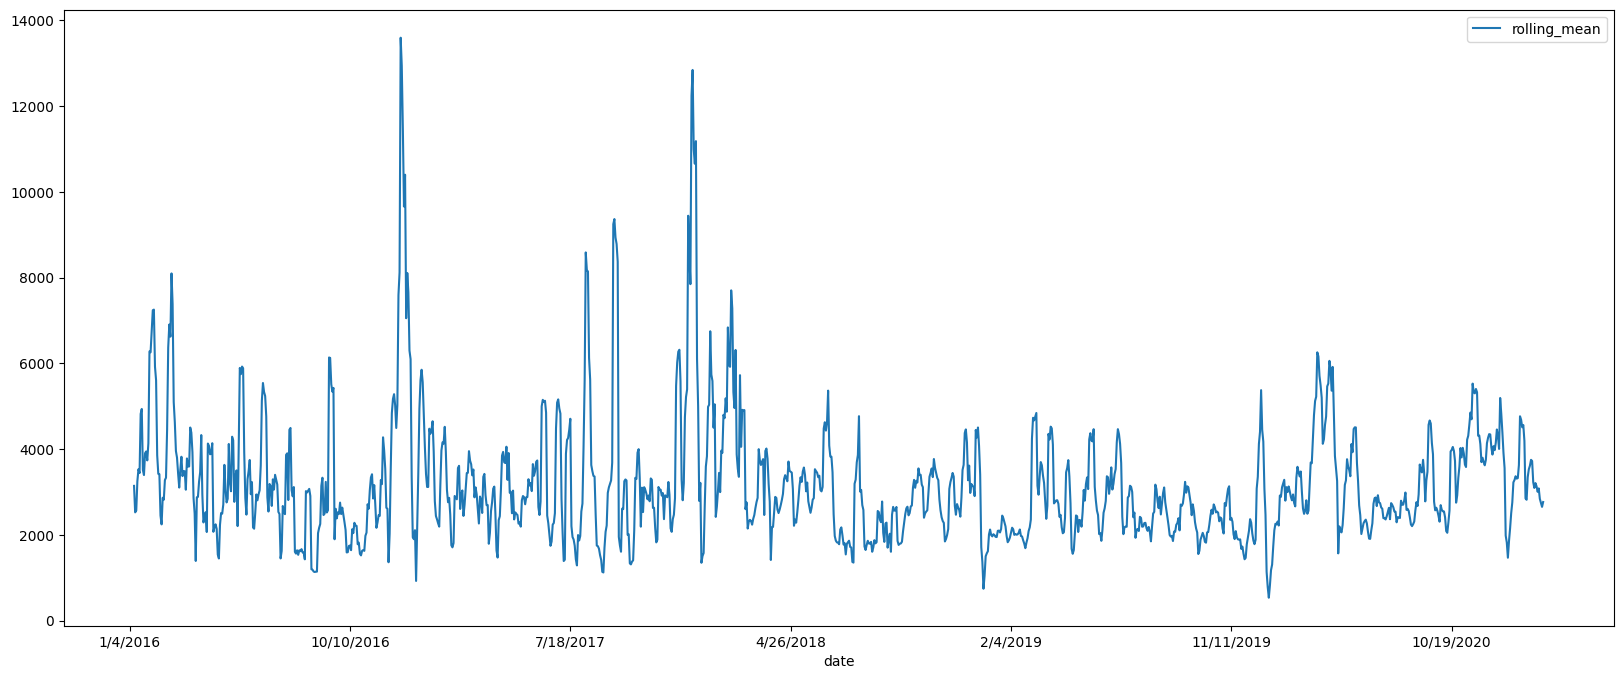

In [273]:
capped_df.plot(y='rolling_mean', figsize=[20, 8])

In [274]:
capped_df["furier_transform"] = np.abs(fft(capped_df["target"].values))

<Axes: xlabel='date'>

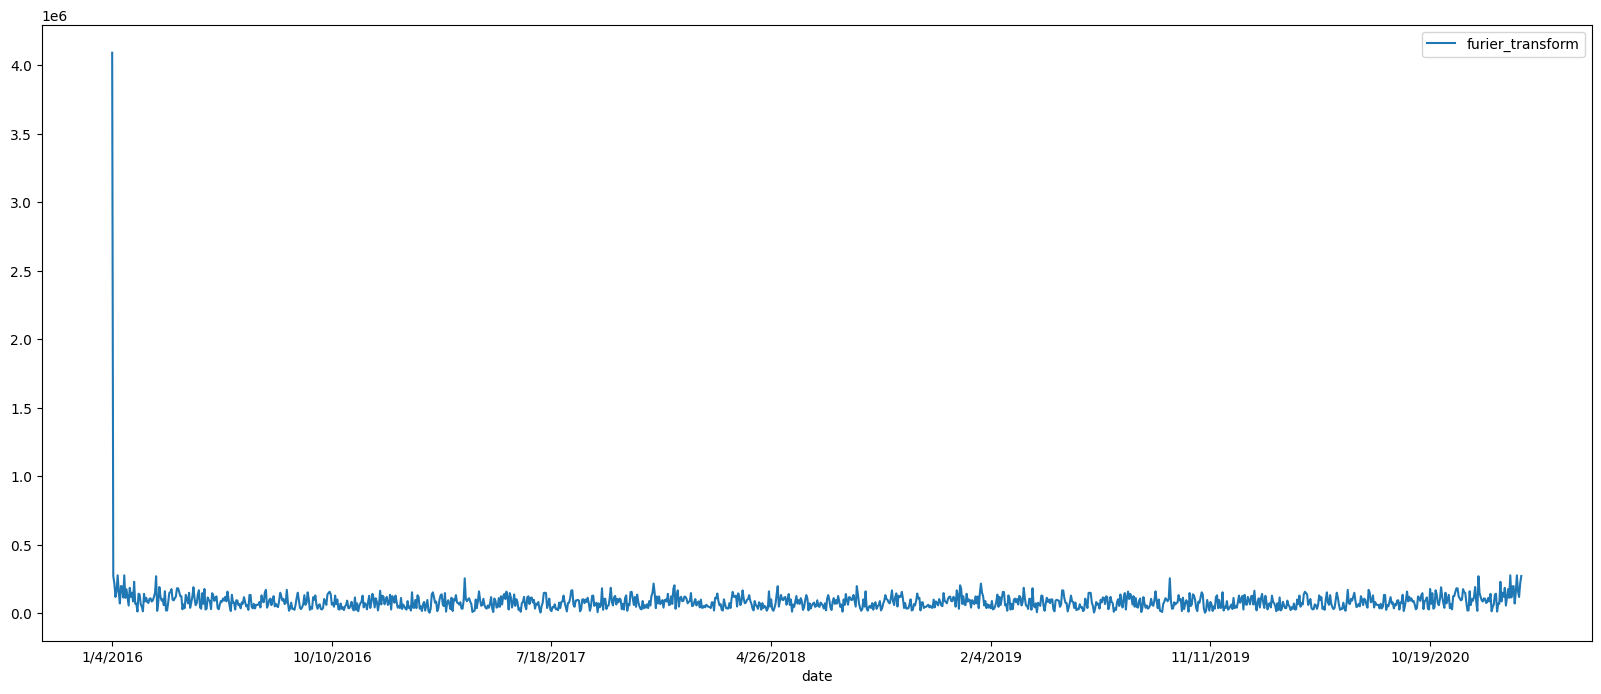

In [275]:
capped_df.plot(y='furier_transform', figsize=[20, 8])

In [276]:
# Remove trend from sp and gold
capped_df["adj_close_sp500_detrend"] = detrend(capped_df['adj_close_sp500'], order=1) #linear
capped_df["adj_close_gold_detrend"] = detrend(capped_df['adj_close_gold'], order=1) #linear
capped_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,target,rolling_mean,furier_transform,adj_close_sp500_detrend,adj_close_gold_detrend
date,,,,,,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.2450,4826.624586,NaN,4.089759e+06,59.963938,-13.571093
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.2480,1751.952884,NaN,2.723919e+05,62.839331,-10.738448
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.1770,5842.829025,NaN,2.158212e+05,35.214846,2.294148
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.1530,1592.794266,NaN,1.191473e+05,-13.129732,17.626672
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.1300,1692.648636,3141.369879,1.620477e+05,-35.364203,7.259367
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.630,3911.229980,4.554610e+09,1835.300049,184.0,1.2104,1.1570,3190.066116,3083.042337,2.770614e+05,456.304830,148.820403
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.1330,2427.720356,2839.003253,1.620477e+05,453.780199,153.652927
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.1580,3232.310708,2747.670244,1.191473e+05,459.105665,137.485571


<Axes: xlabel='date'>

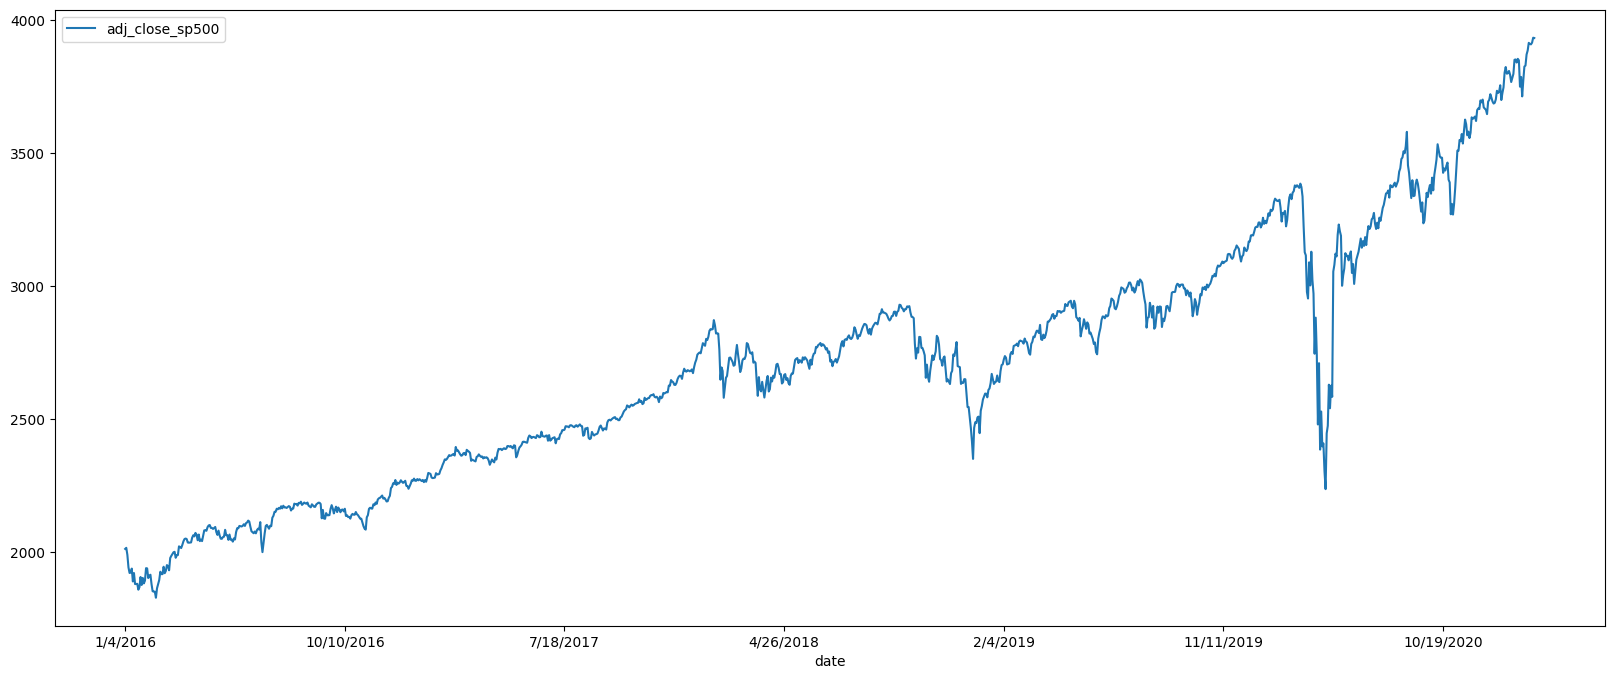

In [277]:
capped_df.plot(y='adj_close_sp500', figsize=[20, 8])

<Axes: xlabel='date'>

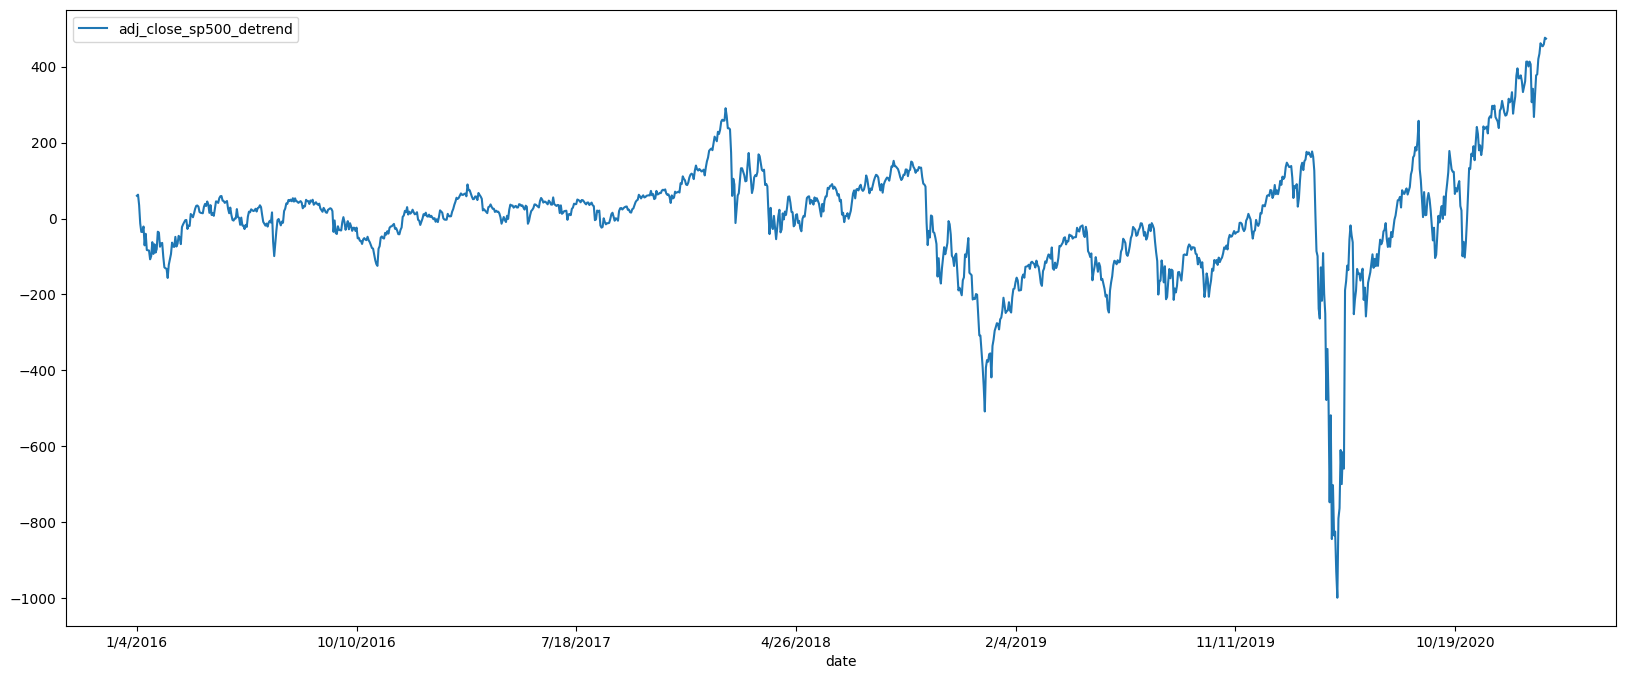

In [278]:
capped_df.plot(y='adj_close_sp500_detrend', figsize=[20, 8])

<Axes: xlabel='date'>

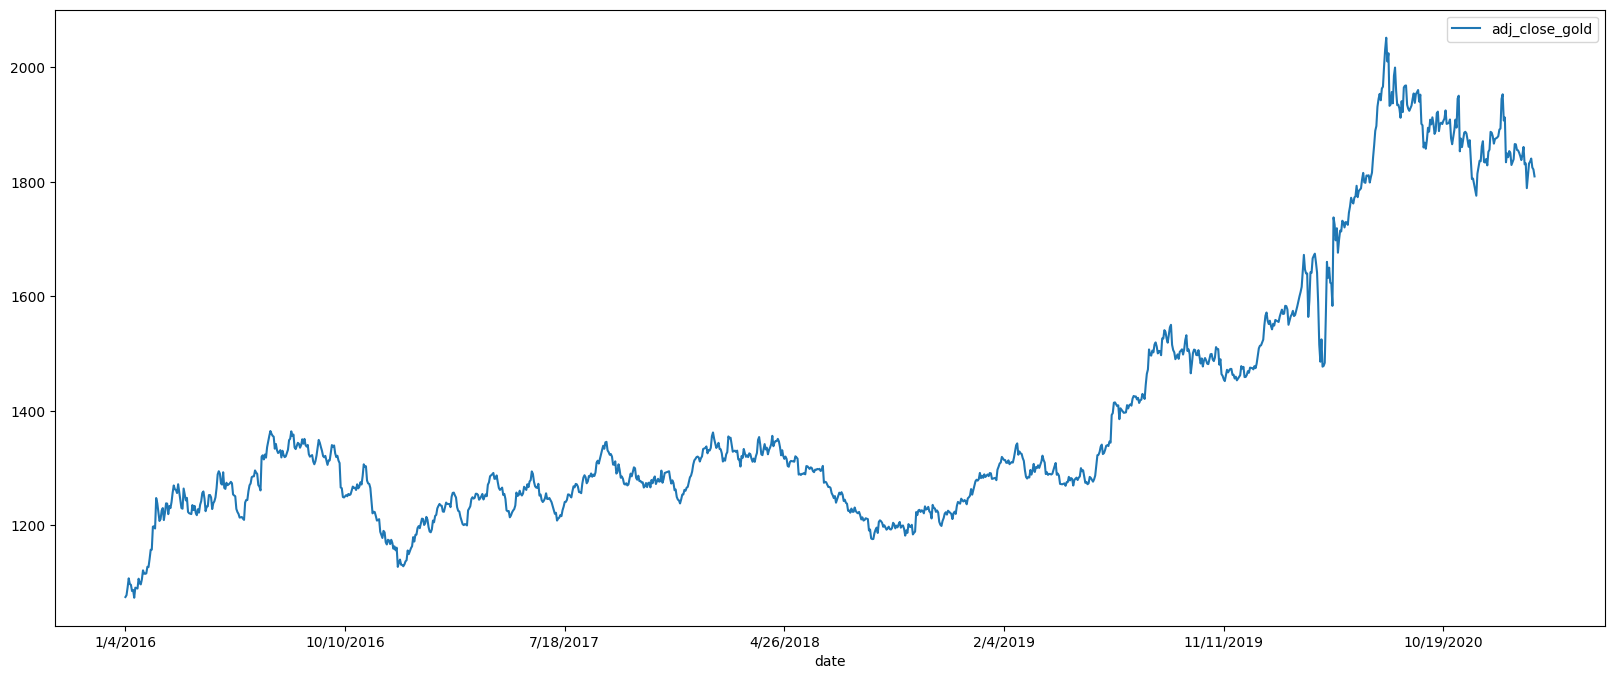

In [279]:
capped_df.plot(y='adj_close_gold', figsize=[20, 8])

<Axes: xlabel='date'>

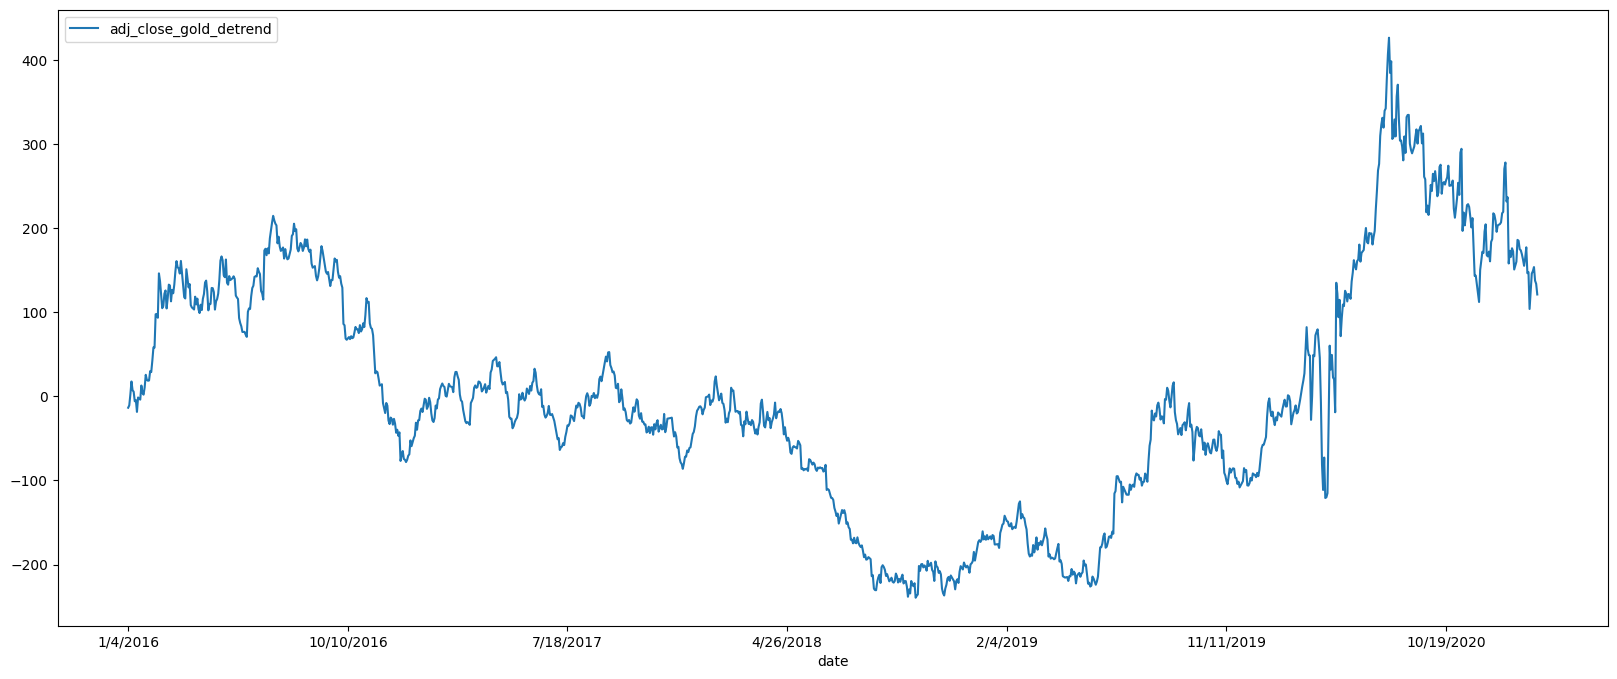

In [280]:
capped_df.plot(y='adj_close_gold_detrend', figsize=[20, 8])

In [281]:
capped_df_no_gold_vol = capped_df.drop(columns=["volume_gold"])

<Axes: xlabel='date'>

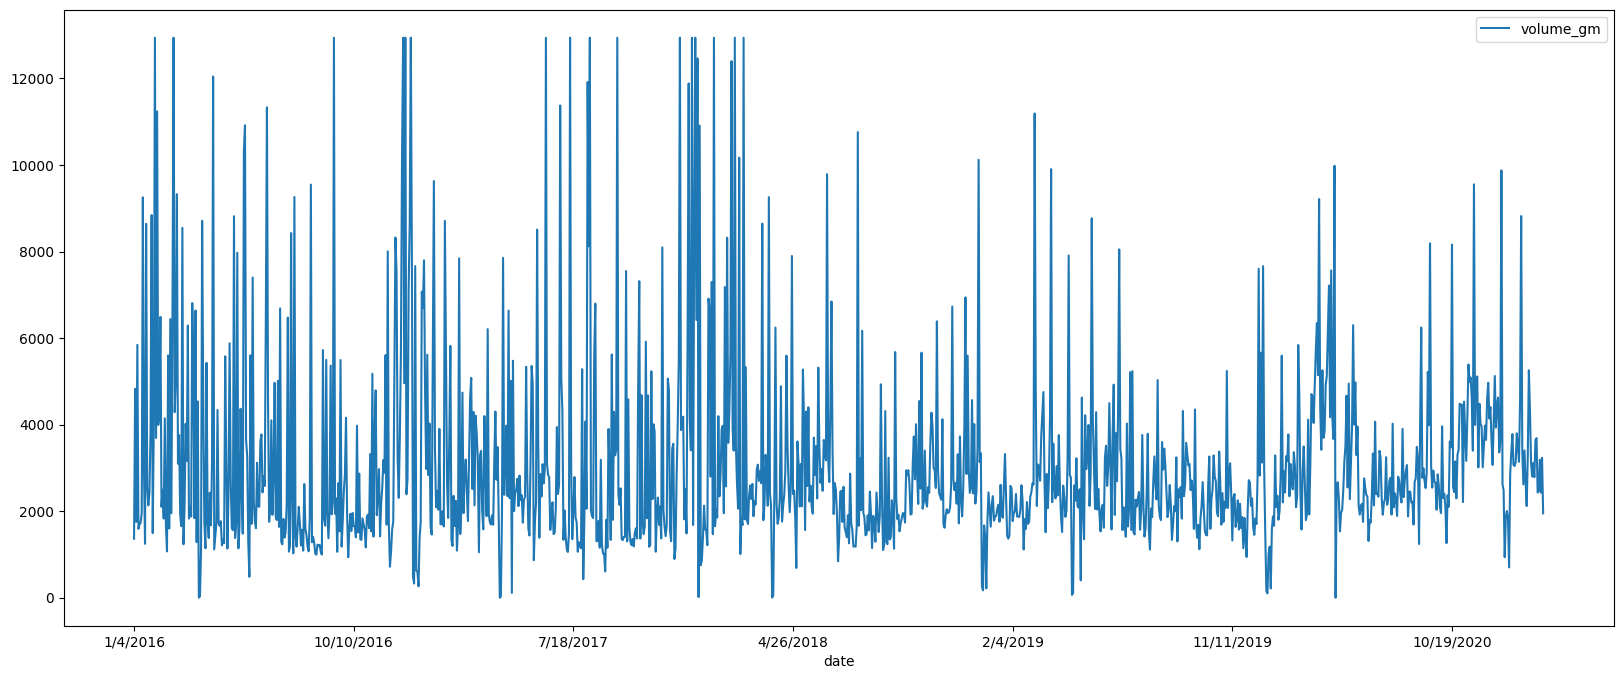

In [282]:
capped_df_no_gold_vol.plot(y='volume_gm', figsize=[20, 8])

In [283]:
# Add lags
capped_lag_df, lag_cols = add_lags(capped_df_no_gold_vol)
capped_lag_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,usd_eurusd,adj_close_bonds,target,rolling_mean,furier_transform,adj_close_sp500_detrend,adj_close_gold_detrend,volume_gm_lag_1,volume_gm_lag_2,volume_gm_lag_3,vix_close_vix_lag_1,vix_close_vix_lag_2,vix_close_vix_lag_3
date,,,,,,,,,,,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,1.0898,2.2450,4826.624586,NaN,4.089759e+06,59.963938,-13.571093,NaN,NaN,NaN,NaN,NaN,NaN
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,1.0746,2.2480,1751.952884,NaN,2.723919e+05,62.839331,-10.738448,1364.873049,NaN,NaN,20.70,NaN,NaN
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,1.0742,2.1770,5842.829025,NaN,2.158212e+05,35.214846,2.294148,4826.624586,1364.873049,NaN,19.34,20.70,NaN
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,1.0868,2.1530,1592.794266,NaN,1.191473e+05,-13.129732,17.626672,1751.952884,4826.624586,1364.873049,20.59,19.34,20.70
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,1.0861,2.1300,1692.648636,3141.369879,1.620477e+05,-35.364203,7.259367,5842.829025,1751.952884,4826.624586,24.99,20.59,19.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.630,3911.229980,4.554610e+09,1835.300049,1.2104,1.1570,3190.066116,3083.042337,2.770614e+05,456.304830,148.820403,2430.570485,3688.975752,3647.915775,21.24,20.87,21.77
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,1.2127,1.1330,2427.720356,2839.003253,1.620477e+05,453.780199,153.652927,2457.683556,2430.570485,3688.975752,21.63,21.24,20.87
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,1.2147,1.1580,3232.310708,2747.670244,1.191473e+05,459.105665,137.485571,3190.066116,2457.683556,2430.570485,21.99,21.63,21.24


- Split in train, test
- Log transform volume_gm and vix
- Create baseline moving average model
- Train ML model
- Deploy

In [284]:
capped_lag_interp_df = capped_lag_df.interpolate()
capped_lag_interp_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,usd_eurusd,adj_close_bonds,target,rolling_mean,furier_transform,adj_close_sp500_detrend,adj_close_gold_detrend,volume_gm_lag_1,volume_gm_lag_2,volume_gm_lag_3,vix_close_vix_lag_1,vix_close_vix_lag_2,vix_close_vix_lag_3
date,,,,,,,,,,,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,1.0898,2.2450,4826.624586,NaN,4.089759e+06,59.963938,-13.571093,NaN,NaN,NaN,NaN,NaN,NaN
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,1.0746,2.2480,1751.952884,NaN,2.723919e+05,62.839331,-10.738448,1364.873049,NaN,NaN,20.70,NaN,NaN
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,1.0742,2.1770,5842.829025,NaN,2.158212e+05,35.214846,2.294148,4826.624586,1364.873049,NaN,19.34,20.70,NaN
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,1.0868,2.1530,1592.794266,NaN,1.191473e+05,-13.129732,17.626672,1751.952884,4826.624586,1364.873049,20.59,19.34,20.70
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,1.0861,2.1300,1692.648636,3141.369879,1.620477e+05,-35.364203,7.259367,5842.829025,1751.952884,4826.624586,24.99,20.59,19.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.630,3911.229980,4.554610e+09,1835.300049,1.2104,1.1570,3190.066116,3083.042337,2.770614e+05,456.304830,148.820403,2430.570485,3688.975752,3647.915775,21.24,20.87,21.77
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,1.2127,1.1330,2427.720356,2839.003253,1.620477e+05,453.780199,153.652927,2457.683556,2430.570485,3688.975752,21.63,21.24,20.87
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,1.2147,1.1580,3232.310708,2747.670244,1.191473e+05,459.105665,137.485571,3190.066116,2457.683556,2430.570485,21.99,21.63,21.24


In [285]:
features = [
    "volume_gm", 
    "vix_close_vix", 
    "adj_close_sp500", 
    "volume_sp500", 
    #"adj_close_gold", 
    "usd_eurusd", 
    "adj_close_bonds",
    "rolling_mean",
    "furier_transform",
    #"adj_close_sp500_detrend",
    #"adj_close_gold_detrend",
    "volume_gm_lag_1",
    "volume_gm_lag_2",
    "volume_gm_lag_3",
    "vix_close_vix_lag_1",
    "vix_close_vix_lag_2",
    "vix_close_vix_lag_3",
]

In [286]:
# Get train and test
new_train_indexes = train_indexes[3:]

In [287]:
train_df = capped_lag_df[features + ["target"]].iloc[train_indexes]
test_df = capped_lag_df[features + ["target"]].iloc[test_indexes]

/var/folders/hg/wkh3wd0x2cdgx68tgss9y0cr0000gn/T/ipykernel_78552/3188754788.py:8: UserWarning: Feature Importance: model is not specified, using CatBoostRegressor
  warnings.warn("Feature Importance: model is not specified, using CatBoostRegressor", UserWarning)


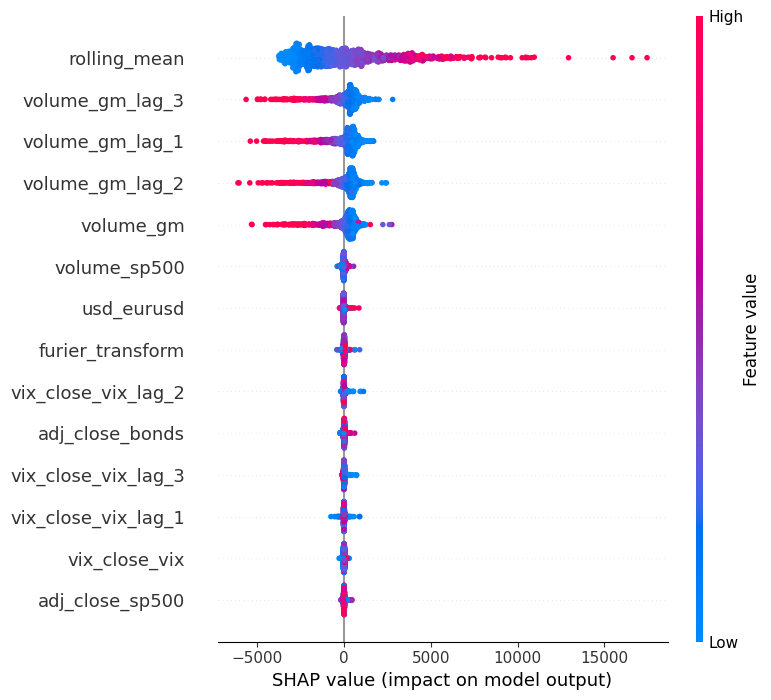

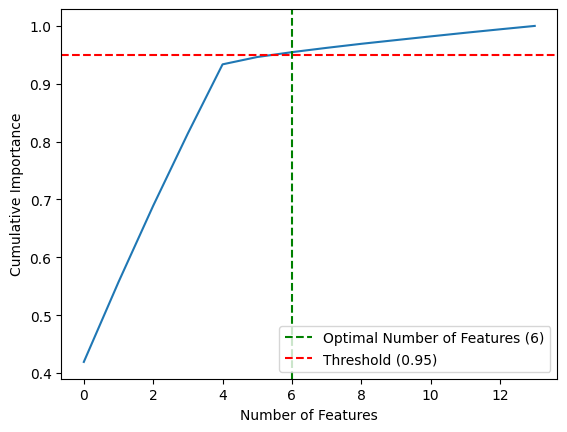

Index(['rolling_mean', 'volume_gm_lag_3', 'volume_gm_lag_1', 'volume_gm_lag_2',
       'volume_gm', 'volume_sp500'],
      dtype='object')

In [288]:
# Evauate feature importance with CatBoost
import warnings
from catboost import CatBoostRegressor
import shap

def evaluate_feature_importance(df: pd.DataFrame,features, model=None, threshold=0.95, plot=True):
    if model is None:
        warnings.warn("Feature Importance: model is not specified, using CatBoostRegressor", UserWarning)
        model = CatBoostRegressor()
    X = df.drop(columns=["target"])
    y = df[["target"]]
    model.fit(X,
            y,
            verbose=0,
            plot=False)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    feature_importance = pd.DataFrame(shap_values, columns=features).abs().sum().sort_values(ascending=False)
    feature_importance_normalized = feature_importance / feature_importance.sum()
    cumulative_importance = feature_importance_normalized.cumsum()
    idx = np.where(cumulative_importance > threshold)[0][0]

    if plot:
        shap.summary_plot(shap_values, X)
        plt.plot(range(len(cumulative_importance)), cumulative_importance)
        plt.axvline(x=idx, color='g', linestyle='--', label=f'Optimal Number of Features ({idx})')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.legend()
        plt.show()

    top_features = feature_importance[cumulative_importance <= threshold].index
    return top_features

evaluate_feature_importance(train_df, features)

In [289]:
top_features = [
    "volume_gm", 
    "vix_close_vix",
    "usd_eurusd", 
    "rolling_mean",
    "volume_gm_lag_1",
    "volume_gm_lag_2",
    "volume_gm_lag_3"
]

In [290]:
X_train = train_df[top_features]
y_train = train_df[["target"]]
X_test = test_df[top_features]
y_test = test_df[["target"]]

In [291]:
# Define pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import xgboost as xgb

def log_transform(x):
    print(x)
    return np.log(x + 1)


preprocessor = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        #("log_transformer", FunctionTransformer(log_transform))
    ]
)
xgb_model = xgb.XGBRegressor(
    eval_metric=root_mean_squared_error,
    learning_rate=0.01,
    max_depth=7,
    subsample=0.8
)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", xgb_model)])

In [292]:
param_grid = {

    'model__learning_rate': [0.01, 0.1, 0.2],

    'model__max_depth': [3, 5, 7],

    'model__subsample': [0.8, 0.9, 1.0]

}

random_search = RandomizedSearchCV(pipe, param_grid, cv=3)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_params

{'model__subsample': 0.8, 'model__max_depth': 3, 'model__learning_rate': 0.2}

In [293]:
mean_score = random_search.cv_results_["mean_test_score"][random_search.best_index_]
std_score = random_search.cv_results_["std_test_score"][random_search.best_index_]

random_search.best_params_, mean_score, std_score

print(f"Best parameters: {random_search.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__subsample': 0.8, 'model__max_depth': 3, 'model__learning_rate': 0.2}
Mean CV score:  0.496731
Standard deviation of CV score:  0.275575


In [294]:
preds = random_search.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, preds)}")
print(f"RMSE: {root_mean_squared_error(y_test, preds)}")
print(f"R2: {r2_score(y_test, preds)}")

MAE: 509.9170934914078
RMSE: 793.9054755707355
R2: 0.7432534376311413


In [295]:
# Train
pipe.fit(X_train, y_train)

preds_ = pipe.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, preds_)}")
print(f"RMSE: {root_mean_squared_error(y_test, preds_)}")
print(f"R2: {r2_score(y_test, preds_)}")

MAE: 821.3758097577881
RMSE: 1223.6089133159505
R2: 0.39010888472827865


<Axes: xlabel='date'>

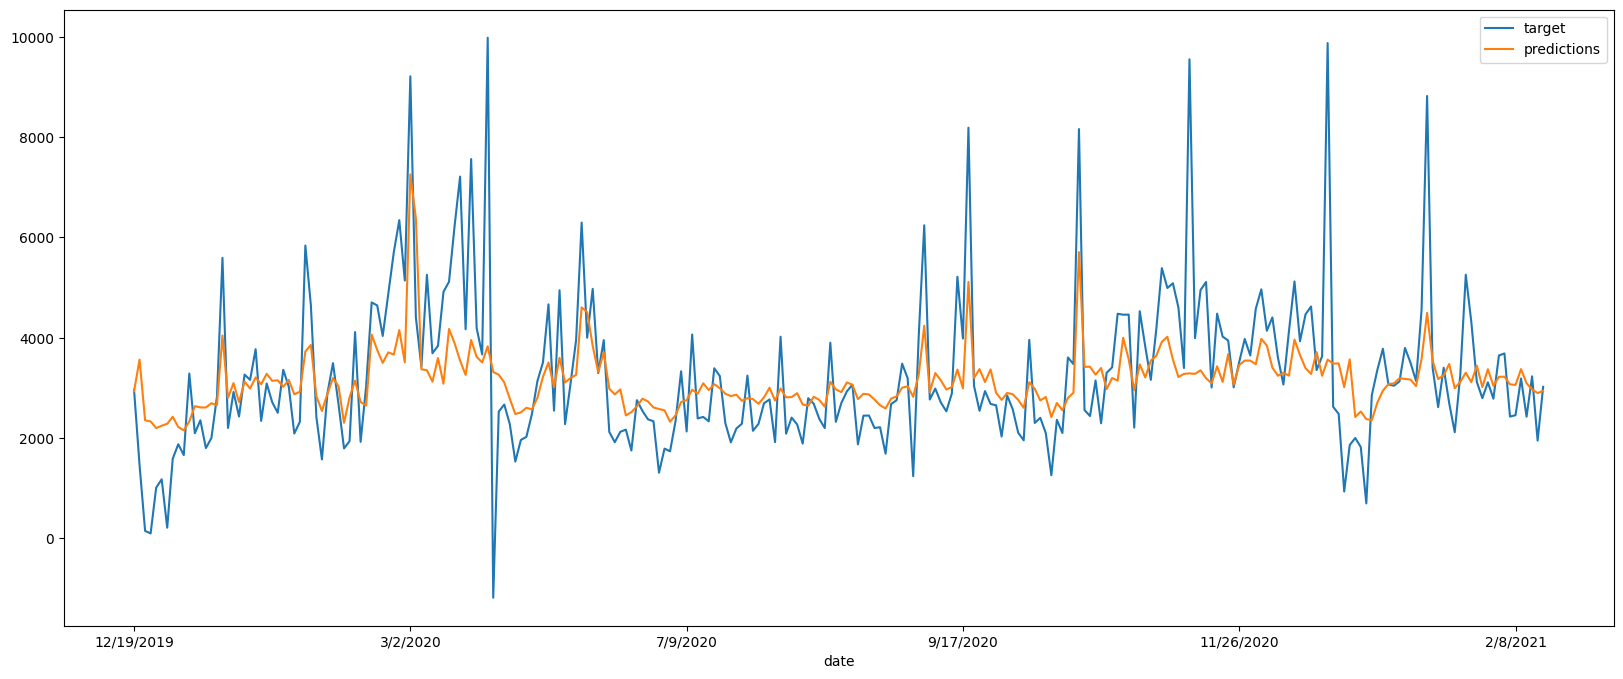

In [296]:
test_df["predictions"] = preds_
test_df["target"].plot(figsize=[20, 8], legend=True)
test_df['predictions'].plot(figsize=[20, 8], legend=True)